# Session length vs. HitRate on DH dataset

This notebook contains the code necessary to produce the figure below. Please note that this notebook is not runnable because the dataset is not included in the repository.


In [ ]:
import os
import numpy as np
import pandas as pd
import pickle
import re
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt

from main.data.session_dataset import SessionDataset
from main.utils.config_util import extract_config
from main.eval.evaluation import Evaluation, EvaluationReport, metrics

In [ ]:
DATASET_FILENAME = "../dh/dataset.pickle"
EXPERIMENTS_FOLDER = "../results/dh/main"

CORES = 1
IS_VERBOSE = True
TOP_K = 20

In [ ]:
dataset = SessionDataset.from_pickle(DATASET_FILENAME)

In [ ]:
all_model_recommendations: list[tuple[str, dict[int, np.ndarray]]] = []

# Get all model recommendation results from the experiments folder.
for rec_file in os.listdir(EXPERIMENTS_FOLDER):
    # Skip unrelated files.
    if not rec_file.startswith("recs_") or not rec_file.endswith(".pickle"):
        continue

    # Parse the model name.
    model_name: str = rec_file.replace("recs_", "").replace(
        ".pickle", ""
    )

    # Load the recommendations.
    with open(f"{EXPERIMENTS_FOLDER}/{rec_file}", mode="rb") as read_file:
        recommendations: dict[int, np.ndarray] = pickle.load(read_file)

    all_model_recommendations.append((model_name, recommendations))

INFO:root:[EVALUATION] Running evaluation on 12 core(s).
INFO:root:[EVALUATION] Computing HitRate@20 started.
INFO:root:[EVALUATION] Computing HitRate@20 completed.
INFO:root:[EVALUATION] Running evaluation on 12 core(s).
INFO:root:[EVALUATION] Computing HitRate@20 started.
INFO:root:[EVALUATION] Computing HitRate@20 completed.
INFO:root:[EVALUATION] Running evaluation on 12 core(s).
INFO:root:[EVALUATION] Computing HitRate@20 started.
INFO:root:[EVALUATION] Computing HitRate@20 completed.
INFO:root:[EVALUATION] Running evaluation on 12 core(s).
INFO:root:[EVALUATION] Computing HitRate@20 started.
INFO:root:[EVALUATION] Computing HitRate@20 completed.
INFO:root:[EVALUATION] Running evaluation on 12 core(s).
INFO:root:[EVALUATION] Computing HitRate@20 started.
INFO:root:[EVALUATION] Computing HitRate@20 completed.
                ground-truth samples there were less than 20 predictions.
INFO:root:[EVALUATION] Running evaluation on 12 core(s).
INFO:root:[EVALUATION] Computing HitRate@20 

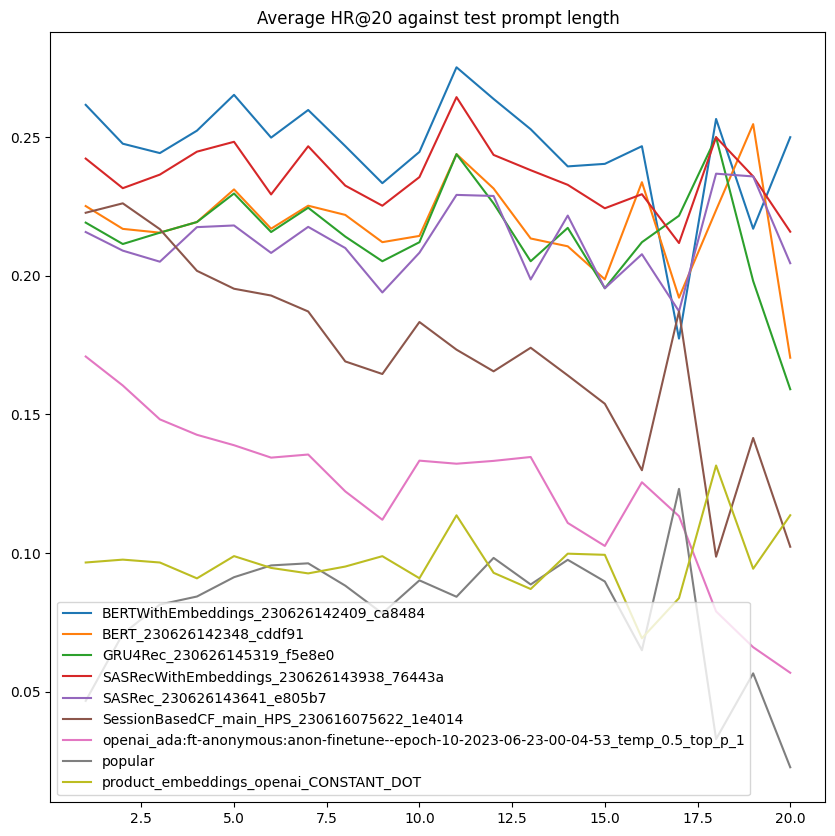

In [12]:
max_len = 20

model_to_prompt_len_to_num_hits = {}
test_prompts = dataset.get_test_prompts()
for model_name, recommendations in all_model_recommendations:
    report: EvaluationReport = Evaluation.eval(
        recommendations,
        dataset.get_test_ground_truths(),
        top_k=TOP_K,
        metrics=[metrics.HitRate()],
        metrics_per_sample=True,
        dependencies={},
        cores=CORES,
        model_name=model_name,
    )

    prompt_len_to_num_hits = {}

    recommendations_keys = list(recommendations.keys())
    prompt_lens = [len(test_prompts[key]) for key in recommendations_keys]

    prompt_len_to_total = dict(Counter(prompt_lens))
    
    for length, hit in zip(prompt_lens, report.results_per_sample["HitRate@20"]):
        if length <= max_len:
            prompt_len_to_num_hits[length] = prompt_len_to_num_hits[length] + hit if length in prompt_len_to_num_hits else hit

    prompt_len_to_avg_hits = {length : prompt_len_to_num_hits[length] * 1.0 / prompt_len_to_total[length] for length in prompt_len_to_num_hits.keys()}

    x, y = zip(*sorted(prompt_len_to_avg_hits.items()))
    plt.plot(x, y, label=model_name)


plt.legend()
plt.title("Average HR@20 against test prompt length")
plt.show()